In [1]:
import numpy as np
import pandas as pd 
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [9]:
all_data = pd.read_csv("mushrooms_limpios.csv")
all_inputs = all_data.iloc[:, 1:].values
all_outputs = all_data.iloc[:, 0].values
scaler = StandardScaler()
all_inputs = scaler.fit_transform(all_inputs)

X_train, X_test, Y_train, Y_test = train_test_split(all_inputs, all_outputs, test_size=1 / 3)
n = X_train.shape[0]

relu = lambda x: np.maximum(x, 0) 
logistic = lambda x: 1 / (1 + np.exp(-x))

np.random.seed(22)
w_hidden = np.random.rand(8, 11)   # pesos primera capa oculta
w_hidden2 = np.random.rand(4, 8)   # pesos segunda capa oculta        
w_output = np.random.rand(1, 4)     # pesos capa de salida

b_hidden = np.random.rand(8, 1)    # sesgos primera capa oculta   
b_hidden2 = np.random.rand(4, 1)    # sesgos segunda capa oculta
b_output = np.random.rand(1, 1)     # sesgos capa de salida   

def forward_prop(X):
    Z1 = w_hidden @ X + b_hidden     
    A1 = relu(Z1)                    
    Z2 = w_hidden2 @ A1 + b_hidden2    
    A2 = relu(Z2)                    
    Z3 = w_output @ A2 + b_output 
    A3 = logistic(Z3)                
    return Z1, A1, Z2, A2, Z3, A3

L = 0.05

d_relu = lambda x: x > 0
d_logistic = lambda x: np.exp(-x) / (1 + np.exp(-x)) ** 2

def backward_prop(Z1, A1, Z2, A2, Z3, A3, X, Y):
    dC_dA3 = 2 * (A3 - Y)           
    dA3_dZ3 = d_logistic(Z3)
    dZ3_dW3 = A2
    dZ3_dA2 = w_output
    dC_dZ3 = dC_dA3 * dA3_dZ3  

    dC_dA2 = dZ3_dA2.T @ dC_dZ3
    dA2_dZ2 = d_relu(Z2)
    dZ2_dW2 = A1
    dZ2_dA1 = w_hidden2
    dC_dZ2 = dC_dA2 * dA2_dZ2

    dC_dA1 = dZ2_dA1.T @ dC_dZ2
    dA1_dZ1 = d_relu(Z1)
    dZ1_dW1 = X
    dC_dZ1 = dC_dA1 * dA1_dZ1

    dC_dW3 = dC_dZ3 @ dZ3_dW3.T
    dC_dB3 = np.sum(dC_dZ3, axis=1, keepdims=True)  

    dC_dW2 = dC_dZ2 @ dZ2_dW2.T
    dC_dB2 = np.sum(dC_dZ2, axis=1, keepdims=True)

    dC_dW1 = dC_dZ1 @ dZ1_dW1.T
    dC_dB1 = np.sum(dC_dZ1, axis=1, keepdims=True)
    
    return dC_dW1, dC_dB1, dC_dW2, dC_dB2, dC_dW3, dC_dB3

accuracy_train_l = []
accuracy_test_l = []

for i in tqdm(range(150_000)):
    idx = np.random.choice(n, 1, replace=False)
    X_sample = X_train[idx].transpose()
    Y_sample = Y_train[idx]

    Z1, A1, Z2, A2, Z3, A3 = forward_prop(X_sample)

    dW1, dB1, dW2, dB2, dW3, dB3 = backward_prop(Z1, A1, Z2, A2, Z3, A3, X_sample, Y_sample)

    w_hidden -= L * dW1
    b_hidden -= L * dB1
    w_hidden2 -= L * dW2
    b_hidden2 -= L * dB2
    w_output -= L * dW3
    b_output -= L * dB3
    
    train_predictions = forward_prop(X_train.transpose())[5]  # Obtener A3 para el conjunto de entrenamiento
    train_comparisons = np.equal((train_predictions >= .5).flatten().astype(int), Y_train)
    accuracy_train = sum(train_comparisons.astype(int)) / X_train.shape[0]
    accuracy_train_l.append(accuracy_train)

    test_predictions = forward_prop(X_test.transpose())[5]  # Obtener A3 para el conjunto de prueba
    test_comparisons = np.equal((test_predictions >= .5).flatten().astype(int), Y_test)
    accuracy_test = sum(test_comparisons.astype(int)) / X_test.shape[0]
    accuracy_test_l.append(accuracy_test)

print("X_train ACCURACY post training: ", accuracy_train)
print("X_test ACCURACY post training: ", accuracy_test)

  0%|          | 0/150000 [00:00<?, ?it/s]

X_train ACCURACY post training:  0.8577450652392105
X_test ACCURACY post training:  0.8593603639769838


<function matplotlib.pyplot.show(close=None, block=None)>

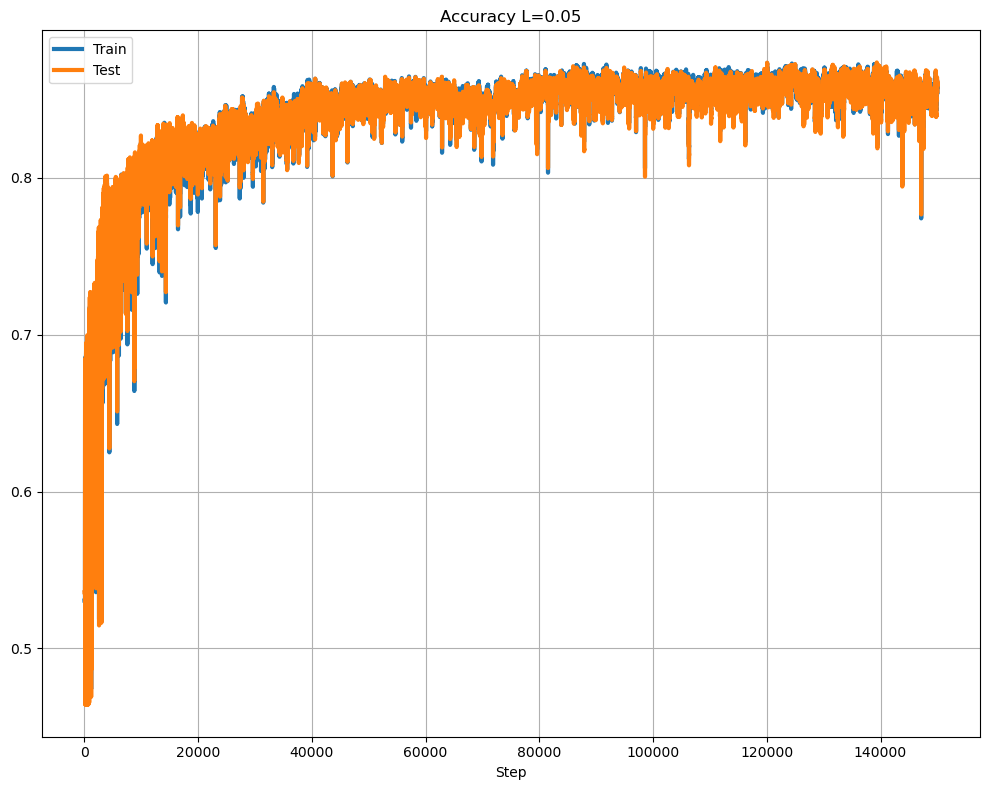

In [10]:
import matplotlib.pyplot as plt

fnt_train = {
    'color': 'tab:blue',
    'ls': 'solid',
    'lw': 3
}

fnt_test = {
    'color': 'tab:orange',
    'ls': 'solid',
    'lw': 3
}

fig, (ax) = plt.subplots(1,1,figsize=(10,8))

ax.plot(accuracy_train_l, label='Train', **fnt_train)
ax.plot(accuracy_test_l, label='Test', **fnt_test)

ax.grid(which='both')
ax.legend()
ax.set_title(f'Accuracy {L=}')
ax.set_xlabel('Step')

fig.tight_layout()
plt.show